In [4]:
# Imports functions into the program
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Imported for categorization of the Sources
from scipy import stats
import astropy.stats as ast
from astropy.visualization import hist
import urllib.request
import lmfit
from importlib import reload

# Import from BB analysis github
import LC
from LC_Set import LC_Set
from fermi_catalog import select_bll, select_fsrq, select_bcu

from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import curve_fit
from scipy.interpolate import SmoothBivariateSpline
import astropy.units as u

In [5]:
# Using the new 2025 dataset. The new dataset has renamed ts2 to return_code2, so the code has been updated accordingly.
table = "new_db_Aug2025.csv"

opened = open(table,"r")
readed = pd.read_csv(table, sep=",", na_filter=True)
readed = readed.fillna(-3333)

cadence = 'weekly'
cadence_df = readed.loc[(readed['cadence'] == cadence) #& \
                        # (readed['ts2'] <= 4.) & \
                        # (readed['photon_flux_error2'] <  readed['photon_flux2'])
                        ]
display(pd.DataFrame(cadence_df))
#cadence_df.loc[cadence_df['ts2'] <= 9., 'photon_flux2'] = -3333
cadence_df.loc[cadence_df['ts2'] <= 4., ['photon_flux2', 'photon_flux_error2']] = -3333
#Jorge: Set as -3333 all points with an error larger than the flux
cadence_df.loc[cadence_df['photon_flux_error2'] > cadence_df['photon_flux2'], ['photon_flux2', 'photon_flux_error2']] = -3333
#Jorge: Set cuts to remove possible outliers due to bad convergence of a bin
cadence_df.loc[cadence_df['photon_flux2'] > 1e-4, ['photon_flux2', 'photon_flux_error2']] = -3333
cadence_df.loc[cadence_df['photon_flux2'] < 1e-10, ['photon_flux2', 'photon_flux_error2']] = -3333
cadence_df.loc[(cadence_df['ts2']<=25) & (cadence_df['photon_flux2'] > 1e-6)] = -3333
#print(cadence_df)
cadence_df = cadence_df.reset_index(drop=True)
TSTART = np.amin(cadence_df['tmin'])
TSTOP = np.amax(cadence_df['tmax'])

names = np.unique(readed['source_name']) #.drop_duplicates(subset=['source_name'], inplace=False)#[1]

fsrq_names = select_fsrq()['Source_Name']
bll_names = select_bll()['Source_Name']
bcu_names = select_bcu()['Source_Name']

df_4lacdr3 = pd.read_csv('4lac_redshifts.csv', delimiter='\t', comment='#')

,Unnamed: 0,source_name,cadence,tmin,tmax,photon_flux2,photon_flux_error2,photon_index2,return_code2,ts2
3050,3050,4FGL J0001.2-0747,weekly,239587201,240192001,-3.333000e+03,-3.333000e+03,-3333.00,0.0,0.51
3051,3051,4FGL J0001.5+2113,weekly,239587201,240192001,1.480000e-08,1.550000e-08,2.12,0.0,1.47
3052,3052,4FGL J0003.3-1928,weekly,239587201,240192001,-3.333000e+03,-3.333000e+03,-3333.00,0.0,0.25
3053,3053,4FGL J0004.3+4614,weekly,239587201,240192001,-3.333000e+03,-3.333000e+03,-3333.00,0.0,0.31
3054,3054,4FGL J0004.4-4737,weekly,239587201,240192001,5.030000e-08,3.010000e-08,3.15,0.0,5.02
...,...,...,...,...,...,...,...,...,...,...
4817470,4817470,4FGL J2358.0-4601,weekly,774835201,775440001,-3.333000e+03,-3.333000e+03,-3333.00,-3333.0,-3333.00
4817471,4817471,4FGL J2358.3-1021,weekly,774835201,775440001,-3.333000e+03,-3.333000e+03,-3333.00,-3333.0,-3333.00
4817472,4817472,4FGL J2358.3+3830,weekly,774835201,775440001,-3.333000e+03,-3.333000e+03,-3333.00,-3333.0,-3333.00
4817473,4817473,4FGL J2359.0+3922,weekly,774835201,775440001,-3.333000e+03,-3.333000e+03,-3333.00,-3333.0,-3333.00


-----------------------------
Selecting FSRQ type blazars
Total number of variable objects: 572
-----------------------------
Selecting BL Lac type blazars
Total number of variable objects: 477
-----------------------------
Selecting unknown type blazars
Total number of variable objects: 364


In [99]:
# Writing the python file here until I'm sure I can export it and be correct.

MJDREFI = 51910
MJDREFF = 7.428703703703703e-4
SecsInDay = 86400
COSI_bkg_rate = 1


def MET_to_MJD(MET,MJDREF=51910):
    return MET/86400 + MJDREF


def quiescent_background_finder(sourcelightcurve, method='forward'):
    # Determines the "quiescent background" of a given lightcurve
    qui = sourcelightcurve
    
    if not hasattr(sourcelightcurve, "hops"):
        sourcelightcurve.find_hop(method='baseline', lc_edges ='add', baseline = thresholdflux)


    if sourcelightcurve.hops is None:
        quiescent_background,qui_err = np.nan, np.nan
        print('No flares detected initially, quiescent background is all bins')
        return quiescent_background, qui_err

    # Mask out flaring regions
    mask = []
    for hop in sourcelightcurve.hops:
        start_idx = np.searchsorted(sourcelightcurve.time, hop.start_time)
        end_idx = np.searchsorted(sourcelightcurve.time, hop.end_time)
        if start_idx < end_idx:
            mask.extend(range(start_idx, end_idx))

    maskindices = np.array(mask)
    
    # Avoid deleting empty list.
    if maskindices.size > 0:
        qui.flux = np.delete(qui.flux, maskindices)
        qui.time = np.delete(qui.time, maskindices)
        qui.flux_error = np.delete(qui.flux_error, maskindices)

    if qui.flux.size == 0:
        print("All time bins were flaring. No quiescent background can be determined.")
        return np.nan, np.nan

    # Compute weighted average of non-flaring sections
    baseaverage = []
    weights = []
    tempavg = []

    if cadence_df['cadence'][0] == 'daily':
        tdiff = 3
    if cadence_df['cadence'][0] == 'weekly':
        tdiff = 7
    if cadence_df['cadence'][0] == 'monthly':
        tdiff = 30


    for i in range(len(qui.flux) - 1):
        tempavg.append(qui.flux[i])

        # Check for time gap or last element
        if i == len(qui.flux) - 2 or (qui.time[i + 1] - qui.time[i] != tdiff):
            if tempavg:
                baseaverage.append(np.nanmean(tempavg))
                weights.append(len(tempavg))
            tempavg = []

    # Computing Weighted Mean, putting failsafes to avoid empty averages.
    if baseaverage and weights:
        quiescent_background = np.average(baseaverage, weights=weights)
    else:
        quiescent_background = np.nan

    qui_err = np.sqrt(np.sum((np.array(qui.flux_error) ** 2) * (1 / len(qui.flux_error)) ** 2)) if len(qui.flux_error) > 0 else 0

    print(f"Quiescent Background: {quiescent_background}, Error: {qui_err}")
    return quiescent_background, qui_err



def LCTimeRange(sourcearray, timerangestart,timerangeend):
    sourcearray = sourcearray[timerangestart:timerangeend]
    return sourcearray

def quiescent_flare_plot(cadence_df,sourcename=None,sourcenum=0,percent = 0.1, MJDREFI=51910, MJDREFF=7.428703703703703e-4,bkg_err = False, factor = 1):
    # Depending on what we are doing analysis on/how our time is binned, we can change the MJDREFI to other values.
    


    if sourcename == None:
        sourcearray = cadence_df[cadence_df['source_name'] == cadence_df['source_name'][sourcenum]]
        titlestring=cadence_df['source_name'][sourcenum]
    else:
        sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
        titlestring=sourcename


    sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
    average_flux = np.mean(sourcearray['photon_flux2'])
    sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)
    time = sourcearray['tmin']/SecsInDay + MJDREFI
    photon_flux = sourcearray['photon_flux2'] * factor
    errors = sourcearray['photon_flux_error2']

    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
    maxflux = np.max(photon_flux)
    minflux =np.min(photon_flux)
    delta_flux = maxflux - minflux
    delta_flux_percent = delta_flux * percent
    thresholdflux = minflux + delta_flux_percent


    # Finding first set of flares using threshold flux.
    sourcelightcurve.get_bblocks(gamma_value=0.05)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)

    #if sourcelightcurve.hops == None:
    #    print("No flares detected for "+str(titlestring))
    #    return None


    # Finding quiescent background.
    quiescent_background, qui_err = quiescent_background_finder(sourcelightcurve,'forward')

        

    # Using quiescent background to find flares again.
    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd')


    #sourcelightcurve.flux = np.subtract(sourcelightcurve.flux,quiescent_background)
    sourcelightcurve.get_bblocks(gamma_value=0.05)
    #sourcelightcurve.get_bblocks_above(threshold = 0)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = quiescent_background)


    
    # Plotting the Lightcurve itself.
    plt.figure(figsize=(16,9))
    plt.xlabel("MJD")
    plt.ylabel('Photon Flux (Photons/$cm^2\u22c5s^{-1}$) (0.1 - 100 GeV)')
    plt.title("Photon Flux vs Time" ' (Source: ' +str(titlestring)+ ')' )
    sourcelightcurve.plot_bblocks(size=2)
    sourcelightcurve.plot_hline(value = quiescent_background, color='green',label='Q BKG',lw=3,linestyle = 'dashed')

    if bkg_err == True:
        y1 = quiescent_background + qui_err
        y2 = quiescent_background - qui_err
        plt.fill_between(sourcelightcurve.time,y1,y2,alpha = 0.3,color='green',label = 'Q BKG Error')

    sourcelightcurve.plot_hop()
    plotting_anomalies()
    plt.legend()

def plotting_anomalies():
    ROCKING_pre50_START   = MET_to_MJD(239557417.000)
    ROCKING_50_START      = MET_to_MJD(273628802.000)

    GC_START              = MET_to_MJD(407898663.000)  
    GC_STOP               = MET_to_MJD(458755204.000)   

    ANOMALY_MET           = MET_to_MJD(542851205.000) 
    START_NEW_PROFILE     = MET_to_MJD(571795205.000) 

    #plt.axvspan((ROCKING_pre50_START), (ROCKING_50_START),
        #color='y', alpha=0.6, label='OLD ROCKING')
    plt.fill_between([ROCKING_pre50_START,ROCKING_50_START],y1=-(np.max(sourcelightcurve.flux)*0.01),y2=0,color='y',alpha=1,label='OLD Rocking')
    plt.fill_between([GC_START,GC_STOP],y1=-(np.max(sourcelightcurve.flux)*0.01),y2=0,color='y',alpha=0.6,label='GC POINTING')
    plt.fill_between([ANOMALY_MET,START_NEW_PROFILE],y1=-(np.max(sourcelightcurve.flux)*0.01),y2=0,color='y',alpha=0.3,label='SOLAR PANEL ANOMALY')

    #plt.axvspan((GC_START),
    #    (GC_STOP),
    #    color='y', alpha=0.40, label='GC POINTING')
    #plt.axvspan((ANOMALY_MET),(START_NEW_PROFILE),
    #    color='y', alpha=0.2, label='SOLAR PANEL ANOMALY')

def fluence_integrator(hops_bl,sourcelightcurve, time = 's',cadence = 'weekly'):
    flarestack=[0,0]
    for i in range(0,len(hops_bl)-1):
        flarefluxes = sourcelightcurve.flux[np.min(hops_bl[i].iis):np.max(hops_bl[i].iis)] # array of flux ph/cm2/s
        if cadence == 'daily':
            flarefluxes = flarefluxes * 3 * 86400
        if cadence == 'weekly':
            flarefluxes = flarefluxes * 7 * 86400
        if cadence == 'monthly':
            flarefluxes = flarefluxes * 30 * 86400

        duration = (hops_bl[i].end_time-hops_bl[i].start_time)*86400 # duration of flare in seconds
        starttime_MJD= hops_bl[i].start_time # start time of flare in MJD
        starttime_s = starttime_MJD * 86400 # start time of flare in seconds
        observation_time = (np.max(sourcelightcurve.time)-np.min(sourcelightcurve.time))*86400 # total observation time in seconds
        portion_of_obs = duration/observation_time
        integral = np.sum(flarefluxes) # sum of flux over duration ph/cm2 for the flare
        background_counts = COSI_bkg_rate * duration
        fluxsum = np.sum(flarefluxes) # sum of flux ph/cm2/s over duration
        flare_asym = hops_bl[i].asym

        print(flarefluxes)
        
        if len(fsrq_names[fsrq_names==sourcelightcurve.name])>0:
            blazartype='FSRQ'
        elif len(bll_names[bll_names==sourcelightcurve.name])>0:
            blazartype='BLL'
        elif len(bcu_names[bcu_names==sourcelightcurve.name])>0:
            blazartype='BCU'
        else:
            blazartype='None'
        
        if len(flarestack)<1:
            flarestack = [sourcelightcurve.name,fluxsum]
        else:
            flarestack = np.vstack((flarestack,[sourcelightcurve.name,fluxsum]))
    return flarestack

def ComputeMDP99(src_counts, bkg_counts, average_mu=0.3):
    
    mdp99 = (4.29 / (average_mu*(src_counts))) * np.sqrt(src_counts+bkg_counts) * 100
    
    return mdp99

def maxwellian_function(x, N, a):
    mu = 2*a*(np.sqrt(2/np.pi))
    return N * (x**2*np.exp(-(x - mu)**2/(2*a**2)))/a**3





In [100]:
table = 'COSICSV/COSI_factors_all_updated_only_logpar_flare_softer_+0.5_updated.csv'

-----------------------------
Selecting FSRQ type blazars
Total number of variable objects: 572
-----------------------------
Selecting BL Lac type blazars
Total number of variable objects: 477
-----------------------------
Selecting unknown type blazars
Total number of variable objects: 364
Quiescent Background: 8.499086757990866e-08, Error: 2.6770234715734885e-09
[0.0949536  0.0586656  0.05285952 0.05122656]
[0.05394816 0.05406912 0.1378944  0.063504   0.0919296  0.05013792
 0.069552   0.0610848  0.0889056  0.0610848  0.03894912 0.03773952
 0.04935168 0.0810432  0.0628992  0.03453408 0.05872608 0.0622944
 0.1052352  0.0731808  0.0973728  0.03707424 0.0798336  0.0756
 0.0659232  0.0671328  0.081648  ]


ValueError: zero-size array to reduction operation minimum which has no identity

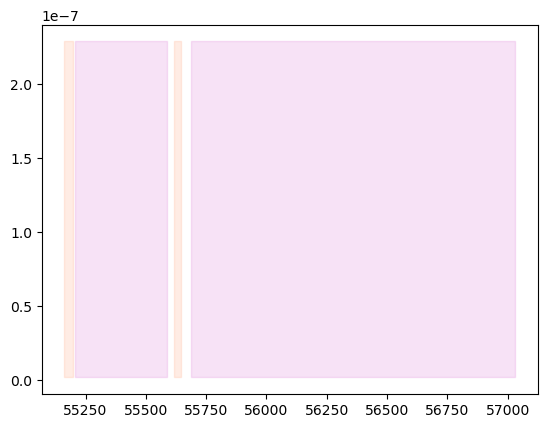

In [103]:
def maxwellian_function(x, N, a):
    mu = 2*a*(np.sqrt(2/np.pi))
    return N * (x**2*np.exp(-(x - mu)**2/(2*a**2)))/a**3


percent = 0.1
COSI_LAT_Sources = pd.read_csv(table, sep=",", na_filter=True)
flare_array = []
COSI_BAND_ALL = np.array([0,0])
#quiescent_flare_plot(cadence_df,sourcename = COSI_LAT_Sources['Name'][p],percent=0.1,bkg_err=True
fsrq_names = select_fsrq()['Source_Name']
bll_names = select_bll()['Source_Name']
bcu_names = select_bcu()['Source_Name']
i=13

Aeff = COSI_LAT_Sources['Aeff_mean_COSI(cm2)'][i]
sourcename = COSI_LAT_Sources['Name'][i]

factor = COSI_LAT_Sources['ph/s_ratio'][i]

sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
titlestring=sourcename
sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
average_flux = np.nanmean(sourcearray['photon_flux2'])
sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)

time = sourcearray['tmin']/SecsInDay + MJDREFI
photon_flux = sourcearray['photon_flux2']
errors = sourcearray['photon_flux_error2']

sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)

maxflux = np.max(photon_flux)
minflux = np.min(photon_flux)
delta_flux = maxflux - minflux
delta_flux_percent = delta_flux * percent
thresholdflux = minflux + delta_flux_percent



sourcelightcurve.get_bblocks(gamma_value=0.05)
sourcelightcurve.find_hop(method='baseline', lc_edges ='add', baseline = thresholdflux)

if not sourcelightcurve.hops:
    print("No flares detected for source "+str(sourcename))

quiescent_background,qui_err = quiescent_background_finder(sourcelightcurve=sourcelightcurve,method='forward')

if quiescent_background == np.nan:
    print("No quiescent background for source "+str(sourcename))

sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = quiescent_background)


hops_bl = sourcelightcurve.hops
sourcelightcurve.plot_hop()
flarestack = fluence_integrator(hops_bl,sourcelightcurve,time='s',cadence='weekly')
print(factor)
flareflux = flarestack[:,1].astype(float)*factor
flarenames = flarestack[:,0]

#quiescent_background_calc_array = np.vstack((quiescent_background_calc_array,np.array([flarenames,flareintegrals,[quiescent_background]*len(flarenames),fraction_time,blazartype]).T))
COSI_BAND = np.array([flarenames,flareflux]).T
COSI_BAND_ALL = np.vstack((COSI_BAND_ALL, COSI_BAND))



COSI_BAND_BAT_weekly_df=pd.DataFrame(COSI_BAND_ALL)
COSI_BAND_BAT_weekly_df.columns=['Name','Photon Flux (ph/cm2/s)']

In [ ]:
sourcename ='4FGL J2253.9+1609'
sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
titlestring=sourcename
print(sourcename)
sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
average_flux = np.nanmean(sourcearray['photon_flux2'])
sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)

time = sourcearray['tmin']/SecsInDay + MJDREFI
photon_flux = sourcearray['photon_flux2']
errors = sourcearray['photon_flux_error2']

print(len(time),len(photon_flux))
sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
sourcelightcurve.get_bblocks(gamma_value=0.05)
sourcelightcurve.find_hop(method='baseline', lc_edges ='add', baseline = thresholdflux)
quiescent_background,qui_err = quiescent_background_finder(sourcelightcurve=sourcelightcurve,method='forward')

if quiescent_background == np.nan:
    print("No quiescent background for source "+str(sourcename))

#sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = quiescent_background)
hops_bl = sourcelightcurve.hops

4FGL J2253.9+1609
841 841
Quiescent Background: 8.975939393939395e-08, Error: 7.151603106270606e-09


TypeError: object of type 'Hopject' has no len()

In [198]:
bkg_rate = 0.05 * 0.25
def hop_characterizer(hops,factor, Aeff, bkg_rate):
    # Given a hop_bl object (object that contains data about each flare), returns an array of characteristics for that each flare.

    # Empty arrays that will store the characteristics of each flare.
    hop_durations = []
    hop_sourcecounts = []
    hop_asymmetries = []
    hop_coverages = []
    hop_background = []
    hop_sourcecounts = []
    hop_MDP99 = []
    hop_name = []
    blazartype = []
    hop_fluences = []
    hop_avg_fluxes = []

    # Loop through each hop and extract its characteristics.
    for hop in hops:
        
        # Since duration is in days (MJD), convert to seconds.
        duration = hop.dur*86400

        # add all flux values, then multiply by Effective Area of COSI, and the conversion factor.
        sourcecounts = np.sum(hop.flux) * 7 * 86400 * factor * Aeff # add all flux values, then multiply by Effective Area of COSI, and the conversion factor.
        
        # Asymmetry of the flare. This is tacked on just in case we want to use it later.
        asymmetry = hop.asym

        # Portion of time the flare is active.
        coverage = hop.coverage

        # Background counts during the flare duration.
        background_counts = duration * bkg_rate 

        # Total fluence during the flare.
        fluence = np.sum(hop.flux) * factor * 7 * 86400   

        # Average flux of the flare.
        avg_flux = fluence / duration

        # Append characteristics to their respective arrays.
        hop_name.append(hop.name)
        hop_durations.append(duration)
        hop_sourcecounts.append(sourcecounts)
        hop_asymmetries.append(asymmetry)
        hop_coverages.append(coverage)
        hop_background.append(background_counts)
        hop_MDP99.append(ComputeMDP99(sourcecounts, background_counts))
        hop_fluences.append(fluence)
        hop_avg_fluxes.append(avg_flux)

        if len(fsrq_names[fsrq_names==sourcelightcurve.name])>0:
            blazartype.append('FSRQ')
        elif len(bll_names[bll_names==sourcelightcurve.name])>0:
            blazartype.append('BLL')
        elif len(bcu_names[bcu_names==sourcelightcurve.name])>0:
            blazartype.append('BCU')
        else:
            blazartype.append('None')
            
    # Return all characteristics
    return hop_name, hop_durations, hop_sourcecounts, hop_asymmetries, hop_coverages, hop_background, hop_MDP99, blazartype, hop_fluences, hop_avg_fluxes

def ComputeMDP99(src_counts, bkg_counts, average_mu=0.3):
    
    mdp99 = (4.29 / (average_mu*(src_counts))) * np.sqrt(src_counts+bkg_counts) * 100
    
    return mdp99


pd.DataFrame(np.array(hop_characterizer(hops_bl, factor=19.37954423113313, Aeff=13.56523910119582, bkg_rate=bkg_rate)).T, columns=['Name','Duration (s)', 'Source Counts (ph)', 'Asymmetry', 'Coverage', 'Background Counts', 'MDP99 (%)', 'Class', 'Photon Fluence (ph/cm2) (0.2-5 MeV)', 'Average Photon Flux (ph/cm2/s) (0.2-5 MeV)'])

,Name,Duration (s),Source Counts (ph),Asymmetry,Coverage,Background Counts,MDP99 (%),Class,Photon Fluence (ph/cm2) (0.2-5 MeV),Average Photon Flux (ph/cm2/s) (0.2-5 MeV)
0,4FGL J2253.9+1609,17841600.0,6947.434763185995,-0.6610169491525424,0.14043583535108958,223020.0,98.70626766468061,FSRQ,512.149819944829,2.8705375075376032e-05
1,4FGL J2253.9+1609,73785600.0,72653.76572412082,0.38524590163934425,0.14285714285714285,922320.0,19.632866942614204,FSRQ,5355.8780042230255,7.258703601004838e-05
2,4FGL J2253.9+1609,275788800.0,75561.79567107589,-0.6008771929824561,0.14097744360902256,3447360.0,35.52100694903339,FSRQ,5570.251663637456,2.0197526743788927e-05
3,4FGL J2253.9+1609,126100800.0,15107.999498065265,-0.3669064748201439,0.14045906132237068,1576260.0,119.40276561658807,FSRQ,1113.728949807707,8.832053006862027e-06


In [140]:
pd.DataFrame(np.array(hop_characterizer(hops_bl)).T, columns=['Duration (s)', 'Fluence (ph/cm2)', 'Asymmetry', 'Coverage'])

,Duration (s),Fluence (ph/cm2),Asymmetry,Coverage
0,17841600.0,3.775334,-0.661017,0.140436
1,73785600.0,39.481085,0.385246,0.142857
2,275788800.0,41.061349,-0.600877,0.140977
3,126100800.0,8.209901,-0.366906,0.140459


In [144]:
hops_bl[0].start_time * 86400

np.float64(4724611201.0)

In [183]:
hops_bl[0].name

'4FGL J2253.9+1609'

In [195]:
hops_bl[0].time[0]-hops_bl[0].time[1]

np.float64(-7.0)

/tmp/ipykernel_70501/1151860047.py:28: RuntimeWarning: divide by zero encountered in divide
  mdp99 = (4.29 / (average_mu*(src_counts))) * np.sqrt(src_counts+bkg_counts)


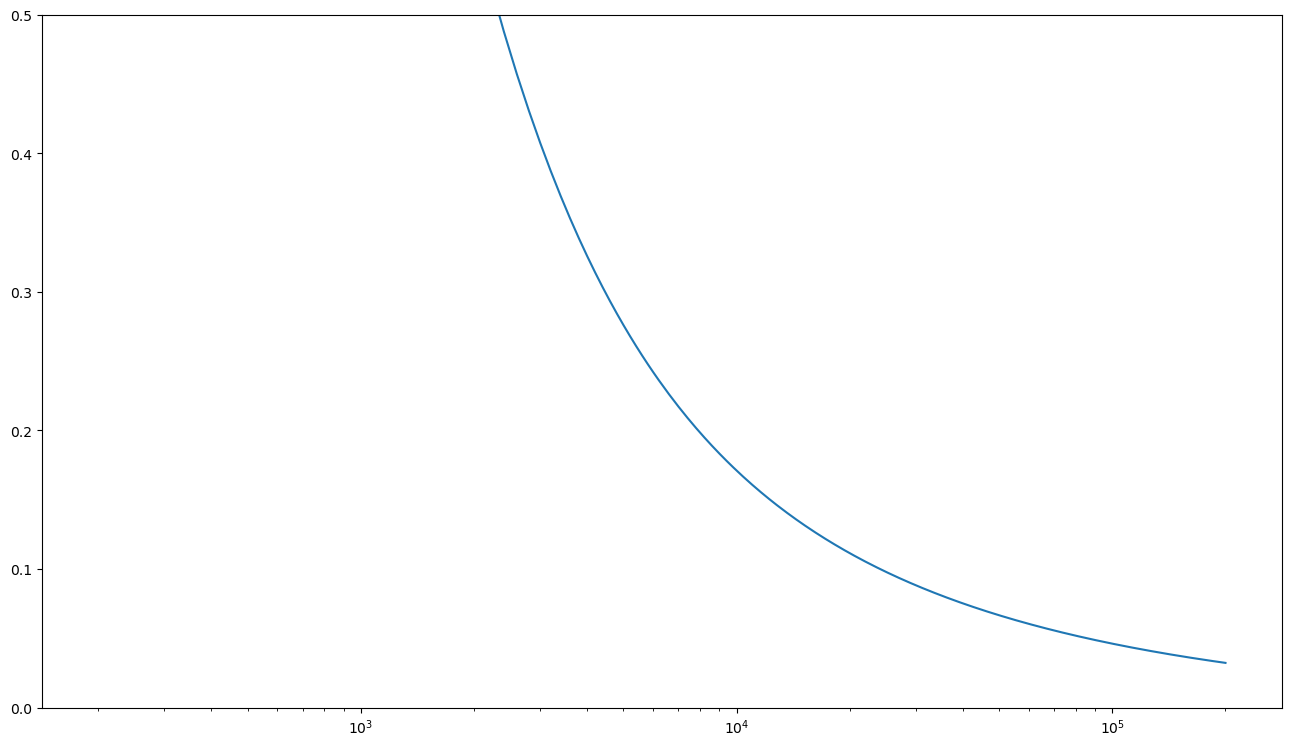

In [170]:
plt.figure(figsize=(16,9))
xtest = np.linspace(0,200000,1000)
ytest = np.linspace(0,120,1000)
plt.ylim(0,0.5)
plt.xscale('log')
plt.plot(xtest, ComputeMDP99(src_counts=xtest, bkg_counts=0.05*86400))